# ClickHouse Query Trace Metrics Analysis

This notebook reads query trace CSV files and computes:
1. **CPU Usage Over Time**: (OSCPUVirtualTimeMicroseconds diff) / (timestamp diff)
2. **CPU Time Provisioned**: (ConcurrencyControlUpscales - ConcurrencyControlDownscales - ConcurrencyControlPreemptions + ConcurrencyControlPreemptionResumes) * timestamp_diff - ConcurrencyControlPreemptedMicroseconds_diff

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

In [2]:
# Configuration - modify this path to your CSV file
csv_path = r"H:\ClickHouse\tpch\output\open\20260127_031855\001_tpch_test_all_rate1_len30_s123_query_traces\001_tpch_all_2526_80cb484f.csv"

In [3]:
def load_trace_data(file_path: str) -> pd.DataFrame:
    """Load CSV trace data and return a DataFrame."""
    df = pd.read_csv(file_path)
    # Remove any empty rows
    df = df.dropna(subset=['timestamp_ms'])
    # Sort by timestamp
    df = df.sort_values('timestamp_ms').reset_index(drop=True)
    return df

df = load_trace_data(csv_path)
print(f"Loaded {len(df)} rows")
df.head()

Loaded 3 rows


,timestamp_ms,AnalyzePatchRangesMicroseconds,ArenaAllocBytes,ArenaAllocChunks,CompressedReadBufferBlocks,CompressedReadBufferBytes,ConcurrencyControlPreemptedMicroseconds,ConcurrencyControlPreemptionResumes,ConcurrencyControlPreemptions,ConcurrencyControlSlotsAcquired,...,SharedPartsLockHoldMicroseconds,SharedPartsLocks,SoftPageFaults,SynchronousReadWaitMicroseconds,SystemTimeMicroseconds,ThreadPoolReaderPageCacheHit,ThreadPoolReaderPageCacheHitBytes,ThreadPoolReaderPageCacheHitElapsedMicroseconds,UserTimeMicroseconds,WaitMarksLoadMicroseconds
0,2541.00,0,0,0,0,0,0,0,0,0,...,7,3,0,0,10,0,0,0,79,0
1,3048.96,8,253952,62,157247,10361048114,2191281,76,79,62,...,7,3,22005,2905748,1293924,38794,5084807168,2865445,8829621,2889
2,3376.78,8,253952,62,237304,15634910622,10264673,164,164,62,...,7,3,25742,3987849,1989143,60217,7890834841,3933284,13456017,3568


In [4]:
def compute_cpu_usage(df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute CPU usage over time.
    CPU Usage = (OSCPUVirtualTimeMicroseconds diff) / (timestamp diff in microseconds)
    
    Returns a DataFrame with timestamp and cpu_usage columns.
    """
    result = df[['timestamp_ms']].copy()
    
    # Calculate diffs
    cpu_time_diff = df['OSCPUVirtualTimeMicroseconds'].diff()
    timestamp_diff_us = df['timestamp_ms'].diff() * 1000  # Convert ms to microseconds
    
    # CPU usage ratio (can be > 1 if multiple cores)
    result['cpu_usage'] = cpu_time_diff / timestamp_diff_us
    
    # First row will be NaN due to diff, drop it
    result = result.iloc[1:].reset_index(drop=True)
    
    return result

cpu_usage_df = compute_cpu_usage(df)
cpu_usage_df.head()

,timestamp_ms,cpu_usage
0,3048.96,19.927831
1,3376.78,16.232176


In [23]:
def compute_cpu_time_provisioned(df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute CPU time provisioned over time.
    
    CPU Time Provisioned = 
        (ConcurrencyControlUpscales - ConcurrencyControlDownscales(if exists) 
         - ConcurrencyControlPreemptions + ConcurrencyControlPreemptionResumes) 
        * timestamp_diff 
        - ConcurrencyControlPreemptedMicroseconds_diff
    
    Returns a DataFrame with timestamp and cpu_time_provisioned columns.
    """
    result = df[['timestamp_ms']].copy()
    
    # Calculate diffs for concurrency control metrics
    upscales_diff = df['ConcurrencyControlUpscales'].diff()
    preemptions_diff = df['ConcurrencyControlPreemptions'].diff()
    resumes_diff = df['ConcurrencyControlPreemptionResumes'].diff()
    
    # Check if ConcurrencyControlDownscales exists
    if 'ConcurrencyControlDownscales' in df.columns:
        downscales = df['ConcurrencyControlDownscales'][1:]
    else:
        downscales = 0
    
    # Timestamp diff in microseconds
    timestamp_diff_us = df['timestamp_ms'].diff() * 1000
    
    # Preempted microseconds diff
    preempted_us_diff = df['ConcurrencyControlPreemptedMicroseconds'].diff()
    
    # Calculate active slots (net change in concurrency)
    active_slots = df['ConcurrencyControlUpscales'][1:] - downscales
    
    # CPU time provisioned = active_slots * time_interval - preemption_overhead
    result['cpu_time_provisioned'] = active_slots * timestamp_diff_us - preempted_us_diff
    result['cpu_core_provisioned'] = (active_slots * timestamp_diff_us - preempted_us_diff) / timestamp_diff_us
    
    # Also store intermediate values for debugging
    result['active_slots'] = active_slots
    result['timestamp_diff_us'] = timestamp_diff_us
    result['preempted_us_diff'] = preempted_us_diff
    
    # First row will be NaN due to diff, drop it
    result = result.iloc[1:].reset_index(drop=True)
    
    return result

cpu_provisioned_df = compute_cpu_time_provisioned(df)
cpu_provisioned_df.head()

,timestamp_ms,cpu_time_provisioned,cpu_core_provisioned,active_slots,timestamp_diff_us,preempted_us_diff
0,3048.96,29302239.0,57.686115,62.0,507960.0,2191281.0
1,3376.78,12251448.0,37.372485,62.0,327820.0,8073392.0


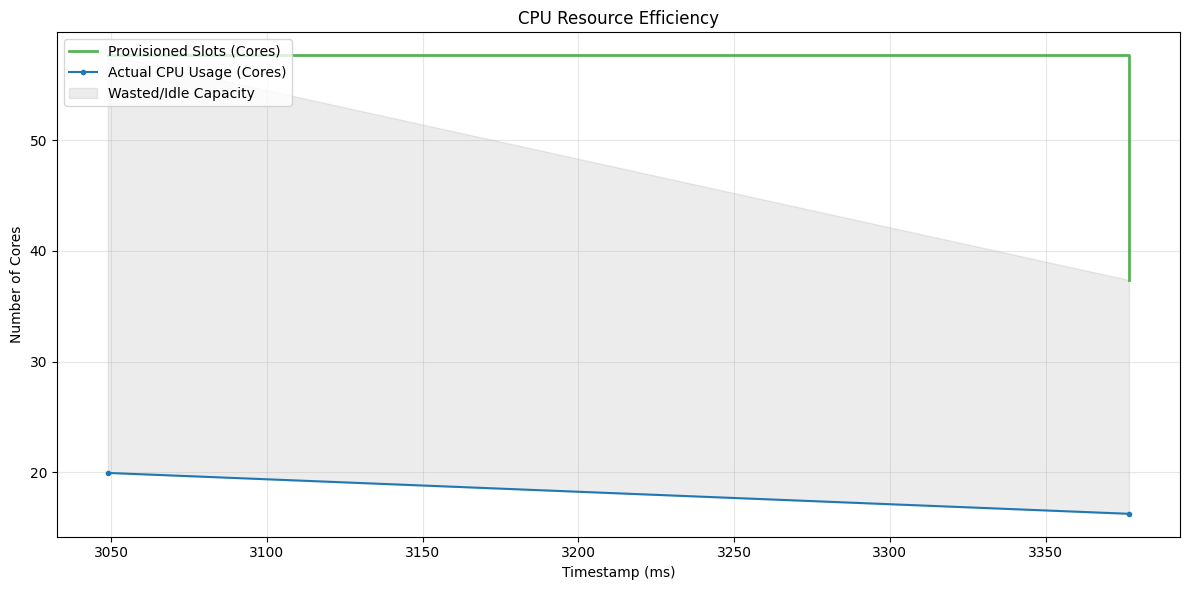

In [28]:
import matplotlib.pyplot as plt

def plot_single_scale_metrics(cpu_usage_df, cpu_provisioned_df, title_suffix=""):
    """
    Plots both metrics on the same Y-axis scale to show utilization efficiency.
    """
    fig, ax = plt.subplots(figsize=(12, 6))

    # --- Provisioned Slots (The Ceiling) ---
    # We use a 'step' plot here because slot allocation changes in discrete jumps
    ax.step(cpu_provisioned_df['timestamp_ms'], 
            cpu_provisioned_df['cpu_core_provisioned'], 
            label='Provisioned Slots (Cores)', 
            color='tab:green', alpha=0.8, linewidth=2, where='post')

    # --- Actual CPU Usage (The Reality) ---
    ax.plot(cpu_usage_df['timestamp_ms'], 
            cpu_usage_df['cpu_usage'], 
            label='Actual CPU Usage (Cores)', 
            color='tab:blue', marker='o', markersize=3, linewidth=1.5)

    # --- Visualizing the Gap (Unused capacity) ---
    ax.fill_between(cpu_usage_df['timestamp_ms'], 
                    cpu_usage_df['cpu_usage'], 
                    cpu_provisioned_df['cpu_core_provisioned'], 
                    color='gray', alpha=0.15, label='Wasted/Idle Capacity')

    ax.set_xlabel('Timestamp (ms)')
    ax.set_ylabel('Number of Cores')
    ax.set_title(f'CPU Resource Efficiency{title_suffix}')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper left')

    plt.tight_layout()
    plt.show()
    return fig

# Usage
fig_single = plot_single_scale_metrics(cpu_usage_df, cpu_provisioned_df)